# Website Fingerprinting Analysis 
#### This notebook evaluates the effectiveness of TrafficSliver in mitigating website fingerprinting (WFP) attacks

_______________________________________________________________________________________________________________
_______________________________________________________________________________________________________________




#### Dataset Preparation and Traffic Splitting Simulation

Dataset Structure: The provided dataset has the following structure:

    ./
    |_ data.zip
       |_ <monitored_page_num>-<trace_num>
       |_ <unmonitored_page_number>

Monitored Pages: Files with names in the format <monitored_page_num>-<trace_num>.
Unmonitored Pages: Files with names that do not contain a hyphen (-).

Filtering Monitored Pages: To isolate only the monitored pages, we used the following command:

    find . -maxdepth 1 -type f ! -name '*-*' -delete

This command removes all files that do not contain a hyphen (-) in their names, leaving only the monitored page files.

_______________________________________________________________________________________________________________


Ensuring .cell Extension: The TrafficSliver simulator requires all dataset files to have a .cell extension. To ensure this, we ran the following command:

    for file in *; do
        if [ -f "$file" ]; then
           mv "$file" "${file}.cell"
       fi
    done

This script renames all files in the directory, appending the .cell extension if not already present.

_______________________________________________________________________________________________________________


Running the TrafficSliver Simulator: To apply TrafficSliver's weighted random traffic splitting mechanism to the monitored dataset, we executed:

    python simulator.py -p monitoredDataset/ -m 3 -o tfMonitoredDataset -s weighted_random -i circuits_latencies_new.txt

Command Breakdown:

-p monitoredDataset/: Specifies the input directory containing the monitored dataset files.

-m 3: Sets the number of paths (multipaths) to use.

-o tfMonitoredDataset: Specifies the output directory where the transformed dataset will be saved.

-s weighted_random: Chooses the "weighted random" traffic splitting scheme.

-i circuits_latencies_new.txt: Provides the file with circuit latencies for simulation.

_______________________________________________________________________________________________________________
_______________________________________________________________________________________________________________


In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def extract_features(file_name, path, labels_dict):
    """
    Extract features from a single file.
    """
    label_key = file_name.split('-')[0]
    label = labels_dict.get(label_key, f"Website {label_key}")
    file_path = os.path.join(path, file_name)

    with open(file_path, 'r') as f:
        packets = [line.strip().split('\t') for line in f]

    directions = [int(packet[1]) for packet in packets]
    timestamps = [float(packet[0]) for packet in packets]
    inter_arrival = np.diff(timestamps) if len(timestamps) > 1 else np.array([0])
    median_inter_arrival = np.median(inter_arrival) if inter_arrival.size > 0 else 0
    outgoing_packets = sum(1 for d in directions if d == 1)
    incoming_packets = sum(1 for d in directions if d == -1)

    burst_sizes = []
    current_burst = 0
    for direction in directions:
        if direction == 1:
            current_burst += 1
        elif current_burst > 0:
            burst_sizes.append(current_burst)
            current_burst = 0

    avg_burst_size = np.mean(burst_sizes) if burst_sizes else 0

    feature_vector = [
        outgoing_packets,
        incoming_packets,
        np.mean(inter_arrival) if inter_arrival.size > 0 else 0,
        np.std(inter_arrival) if inter_arrival.size > 0 else 0,
        median_inter_arrival,
        avg_burst_size,
        len(burst_sizes),  # Burst Count
    ]

    return feature_vector, label

def load_dataset_parallel(path, labels_dict):
    """
    Load dataset using parallel processing for feature extraction.
    """
    file_names = [f for f in os.listdir(path) if f.endswith('.cell')]
    
    # Parallel feature extraction
    results = Parallel(n_jobs=-1)(
        delayed(extract_features)(file_name, path, labels_dict) for file_name in file_names
    )
    
    # Unzip the results into features and labels
    features, labels = zip(*results)
    return np.array(features), np.array(labels)

# Website label mapping (dynamic for the 100 websites)
labels_dict = {str(i): f"Website {i}" for i in range(100)}

In [3]:
# Load datasets in parallel
original_features, original_labels = load_dataset_parallel('monitoredData', labels_dict)
tf_features, tf_labels = load_dataset_parallel('tfMonitoredData', labels_dict)

In [4]:
# Encode class labels
label_encoder = LabelEncoder()
original_labels_encoded = label_encoder.fit_transform(original_labels)
tf_labels_encoded = label_encoder.transform(tf_labels)

# Train-test split
orig_train_x, orig_test_x, orig_train_y, orig_test_y = train_test_split(
    original_features, original_labels_encoded, test_size=0.2, random_state=42
)

tf_train_x, tf_test_x, tf_train_y, tf_test_y = train_test_split(
    tf_features, tf_labels_encoded, test_size=0.2, random_state=42
)

# Scale features for consistency
scaler = StandardScaler()
orig_train_x_scaled = scaler.fit_transform(orig_train_x)
orig_test_x_scaled = scaler.transform(orig_test_x)
tf_train_x_scaled = scaler.fit_transform(tf_train_x)
tf_test_x_scaled = scaler.transform(tf_test_x)

# Random Forest Classifier with Hyperparameter Tuning
rf = RandomForestClassifier(random_state=42)
# Define the parameter grid for randomized search
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

# Use RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(orig_train_x_scaled, orig_train_y)

# Get the best model
best_rf = random_search.best_estimator_
print(f"Best Random Forest Parameters: {random_search.best_params_}")

Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None}


In [5]:
# Evaluate on test set (Original Dataset)
orig_pred = best_rf.predict(orig_test_x_scaled)
orig_accuracy = accuracy_score(orig_test_y, orig_pred)
orig_precision = precision_score(orig_test_y, orig_pred, average='weighted')
orig_recall = recall_score(orig_test_y, orig_pred, average='weighted')
orig_f1 = f1_score(orig_test_y, orig_pred, average='weighted')

print(f"\nOriginal Dataset Performance:")
print(f"Accuracy: {orig_accuracy:.2f}")
print(f"Precision: {orig_precision:.2f}")
print(f"Recall: {orig_recall:.2f}")
print(f"F1 Score: {orig_f1:.2f}")

# Website-specific performance (Original Dataset)
print("\nOriginal Dataset Website-Specific Performance:")
orig_website_specific_report = classification_report(orig_test_y, orig_pred, target_names=label_encoder.classes_, zero_division=0)
print(orig_website_specific_report)


Original Dataset Performance:
Accuracy: 0.76
Precision: 0.77
Recall: 0.76
F1 Score: 0.76

Original Dataset Website-Specific Performance:
              precision    recall  f1-score   support

   Website 0       0.93      1.00      0.96        25
   Website 1       0.80      0.75      0.77        16
  Website 10       0.90      0.95      0.92        19
  Website 11       0.93      0.93      0.93        15
  Website 12       0.83      0.95      0.88        20
  Website 13       0.53      0.69      0.60        13
  Website 14       0.91      1.00      0.95        20
  Website 15       0.93      0.88      0.90        16
  Website 16       0.83      0.68      0.75        22
  Website 17       0.71      1.00      0.83        12
  Website 18       0.80      0.57      0.67        21
  Website 19       0.68      0.85      0.76        20
   Website 2       0.86      1.00      0.92        12
  Website 20       0.90      0.86      0.88        22
  Website 21       0.88      0.88      0.88        

In [6]:
# Evaluate on test set (TrafficSliver Dataset)
tf_pred = best_rf.predict(tf_test_x_scaled)
tf_accuracy = accuracy_score(tf_test_y, tf_pred)
tf_precision = precision_score(tf_test_y, tf_pred, average='weighted', zero_division=0)
tf_recall = recall_score(tf_test_y, tf_pred, average='weighted', zero_division=0)
tf_f1 = f1_score(tf_test_y, tf_pred, average='weighted', zero_division=0)

print(f"\nTrafficSliver Dataset Performance:")
print(f"Accuracy: {tf_accuracy:.2f}")
print(f"Precision: {tf_precision:.2f}")
print(f"Recall: {tf_recall:.2f}")
print(f"F1 Score: {tf_f1:.2f}")

# Website-specific performance (TrafficSliver Dataset)
print("\nTrafficSliver Dataset Website-Specific Performance:")
tf_website_specific_report = classification_report(tf_test_y, tf_pred, target_names=label_encoder.classes_, zero_division=0)
print(tf_website_specific_report)


TrafficSliver Dataset Performance:
Accuracy: 0.02
Precision: 0.03
Recall: 0.02
F1 Score: 0.02

TrafficSliver Dataset Website-Specific Performance:
              precision    recall  f1-score   support

   Website 0       0.00      0.00      0.00        97
   Website 1       0.00      0.00      0.00        69
  Website 10       0.00      0.00      0.00        79
  Website 11       0.04      0.04      0.04        83
  Website 12       0.00      0.00      0.00        63
  Website 13       0.06      0.06      0.06        68
  Website 14       0.00      0.00      0.00        68
  Website 15       0.01      0.02      0.01        43
  Website 16       0.03      0.07      0.04        70
  Website 17       0.05      0.06      0.05        71
  Website 18       0.04      0.07      0.05        84
  Website 19       0.00      0.00      0.00        78
   Website 2       0.02      0.12      0.03        60
  Website 20       0.00      0.00      0.00        68
  Website 21       0.00      0.00      0.

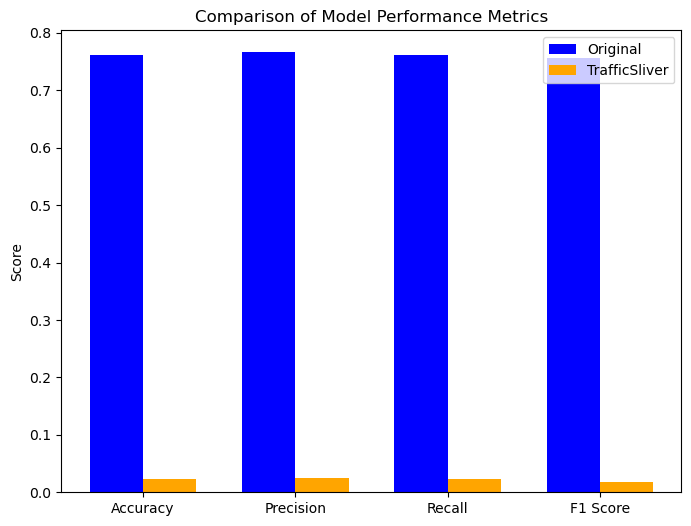

In [7]:
# Comparison of Model Performance Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
original_scores = [orig_accuracy, orig_precision, orig_recall, orig_f1]
tf_scores = [tf_accuracy, tf_precision, tf_recall, tf_f1]

plt.figure(figsize=(8, 6))
x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width / 2, original_scores, width, label='Original', color='blue')
plt.bar(x + width / 2, tf_scores, width, label='TrafficSliver', color='orange')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Comparison of Model Performance Metrics')
plt.legend()
plt.show()

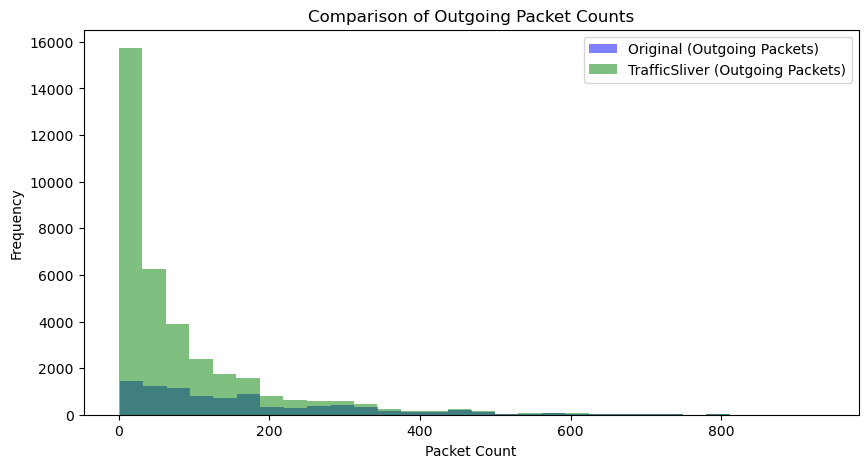

In [8]:
# Compare outgoing packet counts
plt.figure(figsize=(10, 5))

# Original Dataset
plt.hist(original_features[:, 0], bins=30, alpha=0.5, label='Original (Outgoing Packets)', color='blue')
  
# TrafficSliver Dataset
plt.hist(tf_features[:, 0], bins=30, alpha=0.5, label='TrafficSliver (Outgoing Packets)', color='green')

plt.title('Comparison of Outgoing Packet Counts')
plt.xlabel('Packet Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()


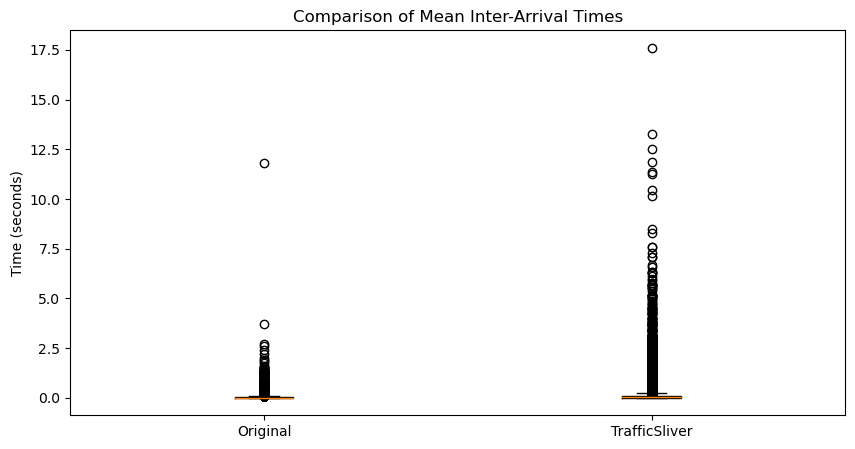

In [9]:
# Compare mean inter-arrival times
plt.figure(figsize=(10, 5))
plt.boxplot([original_features[:, 2], tf_features[:, 2]], labels=['Original', 'TrafficSliver'])
plt.title('Comparison of Mean Inter-Arrival Times')
plt.ylabel('Time (seconds)')
plt.show()

In [10]:
# Dataset Statistics
original_size = sum(os.path.getsize(os.path.join('monitoredData', f)) for f in os.listdir('monitoredData') if f.endswith('.cell'))
tf_size = sum(os.path.getsize(os.path.join('tfMonitoredData', f)) for f in os.listdir('tfMonitoredData') if f.endswith('.cell'))
bandwidth_overhead = ((tf_size - original_size) / original_size) * 100

print(f"Original Dataset Size: {original_size / (1024 * 1024):.2f} MB")
print(f"TrafficSliver Dataset Size: {tf_size / (1024 * 1024):.2f} MB")
print(f"Bandwidth Overhead: {bandwidth_overhead:.2f}%")

# Latency Calculation and Visualization
def calculate_avg_latency(latencies_file):
    latencies = []
    with open(latencies_file, 'r') as f:
        for line in f:
            values = line.strip().split(' ')
            latencies.extend(map(float, values[2].split(',')))
    return np.mean(latencies) * 1000

def calculate_avg_latency_from_dataset(path):
    inter_arrival_times = []
    for file_name in os.listdir(path):
        if file_name.endswith('.cell'):
            file_path = os.path.join(path, file_name)
            with open(file_path, 'r') as f:
                timestamps = [float(line.split('\t')[0]) for line in f if '\t' in line]
                if len(timestamps) > 1:
                    inter_arrival_times.extend(np.diff(timestamps))
    return np.mean(inter_arrival_times) * 1000 if inter_arrival_times else 0

avg_latency = calculate_avg_latency('circuits_latencies_new.txt')
baseline_latency = calculate_avg_latency_from_dataset('monitoredData')
latency_overhead = ((avg_latency - baseline_latency) / baseline_latency) * 100

print(f"Average Latency introduced by TrafficSliver: {avg_latency:.2f} ms")
print(f"Baseline Latency: {baseline_latency:.2f} ms")
print(f"Latency Overhead: {latency_overhead:.2f}%")

Original Dataset Size: 260.64 MB
TrafficSliver Dataset Size: 1018.39 MB
Bandwidth Overhead: 290.72%
Average Latency introduced by TrafficSliver: 95.34 ms
Baseline Latency: 9.08 ms
Latency Overhead: 949.58%


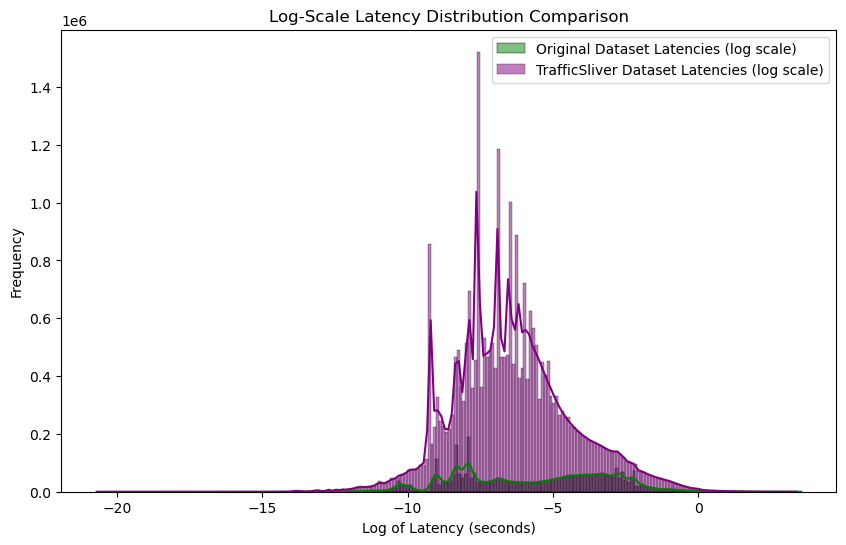

In [11]:
def calculate_latencies(path):
    latencies = []
    for file_name in os.listdir(path):
        if file_name.endswith('.cell'):
            file_path = os.path.join(path, file_name)
            try:
                with open(file_path, 'r') as f:
                    # Extract timestamps from the .cell file
                    timestamps = [
                        float(line.split('\t')[0]) for line in f if '\t' in line and line.strip()
                    ]
                    if len(timestamps) > 1:
                        inter_arrival_times = np.diff(timestamps)
                        latencies.extend(inter_arrival_times)
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    return np.array(latencies)

# Calculate latencies for both datasets
original_latencies = calculate_latencies('monitoredData')
tf_latencies = calculate_latencies('tfMonitoredData')

# Filter out non-positive latencies (if any)
original_latencies = original_latencies[original_latencies > 0]
tf_latencies = tf_latencies[tf_latencies > 0]

# Log-transform latencies for visualization
log_original_latencies = np.log(original_latencies + 1e-9)  # Add a small constant to avoid log(0)
log_tf_latencies = np.log(tf_latencies + 1e-9)

# Plot the distributions
plt.figure(figsize=(10, 6))
sns.histplot(log_original_latencies, kde=True, color='green', label='Original Dataset Latencies (log scale)', binwidth=0.1)
sns.histplot(log_tf_latencies, kde=True, color='purple', label='TrafficSliver Dataset Latencies (log scale)', binwidth=0.1)
plt.title('Log-Scale Latency Distribution Comparison')
plt.xlabel('Log of Latency (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

/tmp/ipykernel_16546/2558645424.py:9: RuntimeWarning: divide by zero encountered in log
  log_tf_sizes = np.log(tf_sizes)


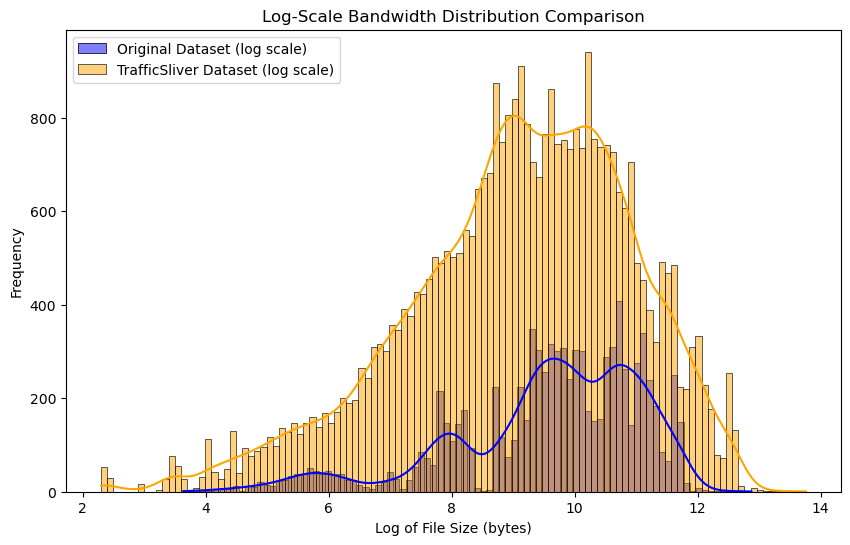

In [ ]:
# Bandwidth Distribution
original_sizes = [os.path.getsize(os.path.join('monitoredData', f)) for f in os.listdir('monitoredData') if f.endswith('.cell')]
tf_sizes = [os.path.getsize(os.path.join('tfMonitoredData', f)) for f in os.listdir('tfMonitoredData') if f.endswith('.cell')]

original_sizes = [size for size in original_sizes if size > 0]
tf_sizes = [size for size in tf_sizes if size > 0]

log_original_sizes = np.log(original_sizes)
log_tf_sizes = np.log(tf_sizes)

plt.figure(figsize=(10, 6))
sns.histplot(log_original_sizes, kde=True, color='blue', label='Original Dataset (log scale)', binwidth=0.1)
sns.histplot(log_tf_sizes, kde=True, color='orange', label='TrafficSliver Dataset (log scale)', binwidth=0.1)
plt.title('Log-Scale Bandwidth Distribution Comparison')
plt.xlabel('Log of File Size (bytes)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

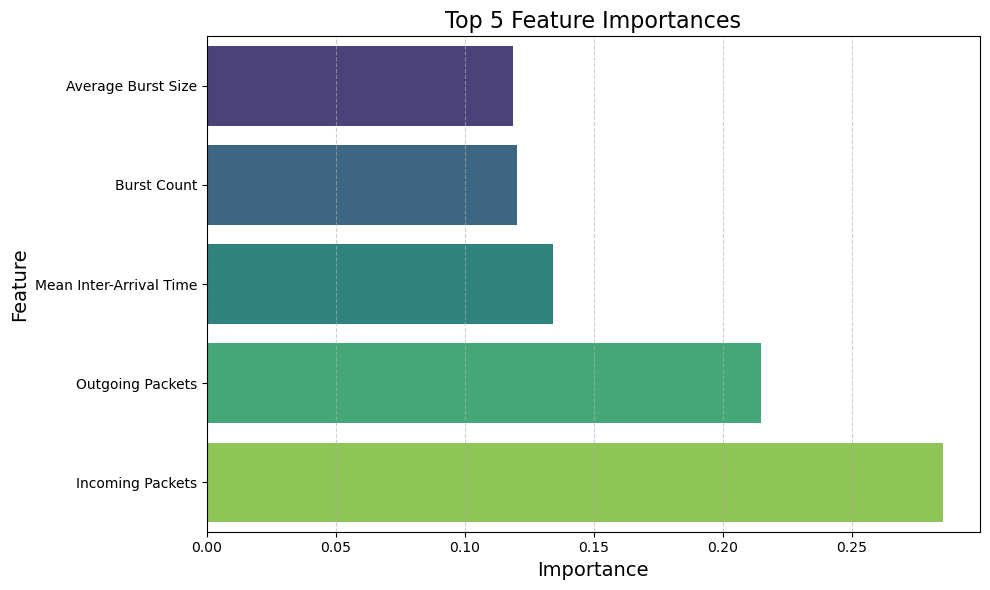

In [13]:
# Feature Importance Comparison
plt.figure(figsize=(12, 6))
importances = best_rf.feature_importances_
feature_names = np.array(['Outgoing Packets', 'Incoming Packets', 'Mean Inter-Arrival Time', 
                          'Std Dev Inter-Arrival Time', 'Median Inter-Arrival Time', 
                          'Average Burst Size', 'Burst Count'])  # Feature names
# Ensure the number of features and their importances match
assert len(importances) == len(feature_names), "Mismatch between feature names and importances."
# Select top N features
top_n = 5
top_indices = np.argsort(importances)[-top_n:]  # Indices of the top N features
top_features = feature_names[top_indices]  # Names of the top N features
top_importances = importances[top_indices]  # Corresponding importances

# Sort the top features by importance for better visualization
sorted_indices = np.argsort(top_importances)
top_features = top_features[sorted_indices]
top_importances = top_importances[sorted_indices]

# Plot the top features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, hue=top_features, palette="viridis", dodge=False, legend=False)
plt.title("Top 5 Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


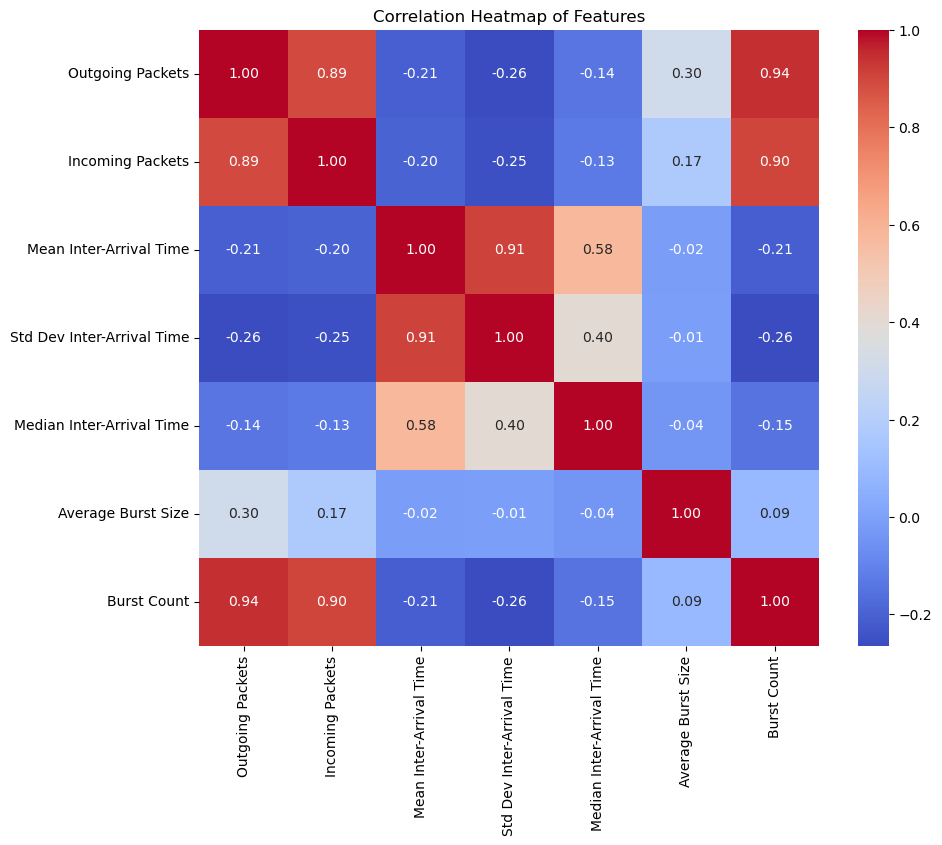

In [14]:
# Correlation heatmap
corr_df = pd.DataFrame(original_features, columns=feature_names)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

In [15]:
# Confusion Matrices
orig_cm_values = confusion_matrix(orig_test_y, orig_pred)
tf_cm_values = confusion_matrix(tf_test_y, tf_pred)

# Extract Significant Misclassifications from Original Dataset (with a threshold)
misclass_threshold = 5 # Set a threshold for significant misclassifications
print("\nMisclassifications from Original Dataset:")
for i in range(orig_cm_values.shape[0]):
    for j in range(orig_cm_values.shape[1]):
        if i != j and orig_cm_values[i, j] > misclass_threshold:
            print(f"Misclassified {label_encoder.classes_[i]} as {label_encoder.classes_[j]}: {orig_cm_values[i, j]} instances")


# Extract Significant Misclassifications from TrafficSliver Dataset (with a threshold)
print("\nMisclassifications from TrafficSliver Dataset:")
for i in range(tf_cm_values.shape[0]):  # Loop through each row (true class)
    for j in range(tf_cm_values.shape[1]):  # Loop through each column (predicted class)
        if i != j and tf_cm_values[i, j] > misclass_threshold:  # If it's not the diagonal (i.e., a misclassification)
            print(f"Misclassified {label_encoder.classes_[i]} as {label_encoder.classes_[j]}: {tf_cm_values[i, j]} instances")



Misclassifications from Original Dataset:
Misclassified Website 36 as Website 39: 7 instances
Misclassified Website 93 as Website 56: 6 instances

Misclassifications from TrafficSliver Dataset:
Misclassified Website 0 as Website 31: 6 instances
Misclassified Website 0 as Website 48: 19 instances
Misclassified Website 0 as Website 51: 6 instances
Misclassified Website 0 as Website 67: 10 instances
Misclassified Website 0 as Website 89: 19 instances
Misclassified Website 1 as Website 22: 9 instances
Misclassified Website 1 as Website 82: 6 instances
Misclassified Website 1 as Website 89: 30 instances
Misclassified Website 10 as Website 51: 10 instances
Misclassified Website 10 as Website 75: 9 instances
Misclassified Website 10 as Website 89: 6 instances
Misclassified Website 11 as Website 16: 6 instances
Misclassified Website 11 as Website 2: 11 instances
Misclassified Website 11 as Website 69: 18 instances
Misclassified Website 12 as Website 48: 9 instances
Misclassified Website 12 as